<a href="https://colab.research.google.com/github/canamac/zeka-can/blob/main/breakout4saat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Cloning https://github.com/rongardF/tvdatafeed to /tmp/pip-req-build-72h3z96r
  Running command git clone --filter=blob:none --quiet https://github.com/rongardF/tvdatafeed /tmp/pip-req-build-72h3z96r
  Resolved https://github.com/rongardF/tvdatafeed to commit e6f6aaa7de439ac6e454d9b26d2760ded8dc4923
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 472.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 15.9 MB/s eta 0:00:00
  Created wheel for tvdatafeed: filename=tvdatafeed-2.1.0-py3-none-any.whl size=17533 sha256=14f6b4386f510582fc523d2636178477cbb51b24f6dc654127f1a61742ad0b37
  Stored in directory: /tmp/pip-ephem-wheel-cache-7hpvs10l/wheels/e4/32/1e/21ebcacc6549d75fae3bf3ff75cee8fcbe4e5c189d88fbd5a1
Successfully built tvdatafeed
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency res

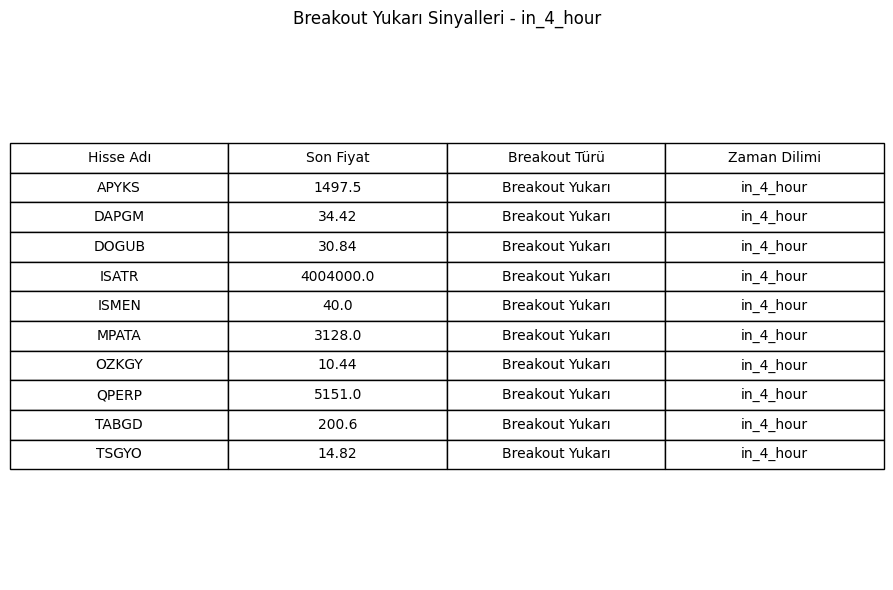


Tüm breakout sinyalleri 'breakout_signals.xlsx' dosyasına kaydedildi.


In [ ]:
# Gerekli kütüphaneleri yükleyin
!pip install git+https://github.com/rongardF/tvdatafeed tradingview-screener matplotlib openpyxl

import pandas as pd
import numpy as np
from tvDatafeed import TvDatafeed, Interval
from tradingview_screener import get_all_symbols
import warnings
import matplotlib.pyplot as plt
from tabulate import tabulate

warnings.simplefilter(action='ignore', category=FutureWarning)

def breakout_strategy(data, period=20):
    df = data.copy()
    df['High_Max'] = df['High'].rolling(window=period).max()
    df['Low_Min'] = df['Low'].rolling(window=period).min()
    df['Breakout_Up'] = df['Close'] > df['High_Max'].shift(1)
    df['Breakout_Down'] = df['Close'] < df['Low_Min'].shift(1)
    return df

tv = TvDatafeed()
Hisseler = get_all_symbols(market='turkey')
Hisseler = [symbol.replace('BIST:', '') for symbol in Hisseler]
Hisseler = sorted(Hisseler)

# 2 Saatlik, 4 Saatlik ve Günlük veriler için döngü
intervals = [Interval.in_4_hour]

df_all_signals = pd.DataFrame(columns=['Hisse Adı', 'Son Fiyat', 'Breakout Türü', 'Zaman Dilimi'])

for interval in intervals:
    df_signals_up = []
    df_signals_down = []
    for i in range(0, len(Hisseler)):
        try:
            data = tv.get_hist(symbol=Hisseler[i], exchange='BIST', interval=interval, n_bars=500)
            data.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
            data = data.reset_index()
            breakout_data = breakout_strategy(data, period=20)
            breakout_data['datetime'] = pd.to_datetime(breakout_data['datetime'])
            breakout_data.set_index('datetime', inplace=True)
            last_signal = breakout_data.iloc[-1]
            Breakout_Up = last_signal['Breakout_Up']
            Breakout_Down = last_signal['Breakout_Down']
            Last_Price = last_signal['Close']
            if Breakout_Up:
                df_signals_up.append([Hisseler[i], Last_Price, 'Breakout Yukarı', interval.name])
                df_all_signals.loc[len(df_all_signals)] = [Hisseler[i], Last_Price, 'Breakout Yukarı', interval.name]
            elif Breakout_Down:
                df_signals_down.append([Hisseler[i], Last_Price, 'Breakout Aşağı', interval.name])
                df_all_signals.loc[len(df_all_signals)] = [Hisseler[i], Last_Price, 'Breakout Aşağı', interval.name]
        except Exception as e:
            print(f"Error processing {Hisseler[i]}: {e}")

    # Print Breakout Yukarı Sinyalleri
    if df_signals_up:
        df_up = pd.DataFrame(df_signals_up, columns=['Hisse Adı', 'Son Fiyat', 'Breakout Türü', 'Zaman Dilimi'])
        plt.figure(figsize=(10, 6))
        plt.title(f'Breakout Yukarı Sinyalleri - {interval.name}')
        table_up = plt.table(cellText=df_up.values, colLabels=df_up.columns, cellLoc='center', loc='center')
        table_up.auto_set_font_size(False)
        table_up.set_fontsize(10)
        table_up.scale(1.5, 1.5)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(f'breakout_yukari_{interval.name}.png')
        plt.show()

    # Print Breakout Aşağı Sinyalleri
    #if df_signals_down:
    #    df_down = pd.DataFrame(df_signals_down, columns=['Hisse Adı', 'Son Fiyat', 'Breakout Türü', 'Zaman Dilimi'])
    #    plt.figure(figsize=(10, 6))
    #    plt.title(f'Breakout Aşağı Sinyalleri - {interval.name}')
    #    table_down = plt.table(cellText=df_down.values, colLabels=df_down.columns, cellLoc='center', loc='center')
    #    table_down.auto_set_font_size(False)
    #    table_down.set_fontsize(10)
    #    table_down.scale(1.5, 1.5)
    #    plt.axis('off')
    #    plt.tight_layout()
    #    plt.savefig(f'breakout_asagi_{interval.name}.png')
    #    plt.show()


    # Excel dosyasına kaydetme
    excel_file = 'breakout_signals.xlsx'
    df_all_signals.to_excel(excel_file, index=False)
    print(f"\nTüm breakout sinyalleri '{excel_file}' dosyasına kaydedildi.")